<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-EVA6-Phase1/blob/main/09-%20Resnets%20and%20Higher%20Receptive%20Fields/S09_ImageClassify_Cifar_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification on Cifar10 dataset.

## motleyNet- Deep Learning library

In [1]:
!git clone https://github.com/Shashank-Holla/motleyNet

fatal: destination path 'motleyNet' already exists and is not an empty directory.


## Necessary packages

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, utils
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR 

import numpy as np
!pip install -U -q git+https://github.com/albu/albumentations --no-cache-dir
# print('Albumentations version:',albumentations.__version__)

In [3]:
from motleyNet.data.dataset import CIFAR10
from motleyNet.data.transform import albumentation_transform
from motleyNet.models import resnet, MixedResNet9
from motleyNet.utils.gradcam import gradcam, gradcam_utils
from motleyNet.utils.image_utilities import utils
from motleyNet.test import test
from motleyNet.train import train
from motleyNet.utils.lr_finder import LRFinder

## Visualize data

In [4]:
viz_data = CIFAR10.cifar10(root='./data', train=True, download=True, transform=None)
classes = viz_data.classes

Files already downloaded and verified


In [5]:
print("Classes of CIFAR10 dataset", classes)

Classes of CIFAR10 dataset ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
print(utils.dataset_calculate_mean_std())

Files already downloaded and verified
Files already downloaded and verified
([0.24697121432552785, 0.24338893940435022, 0.2615925905215076], [0.4918687788500817, 0.4826539051649305, 0.44717727749693625])


In [7]:
mean=[0.4919, 0.4827, 0.4472]
stddev=[0.2470, 0.2434, 0.2616]

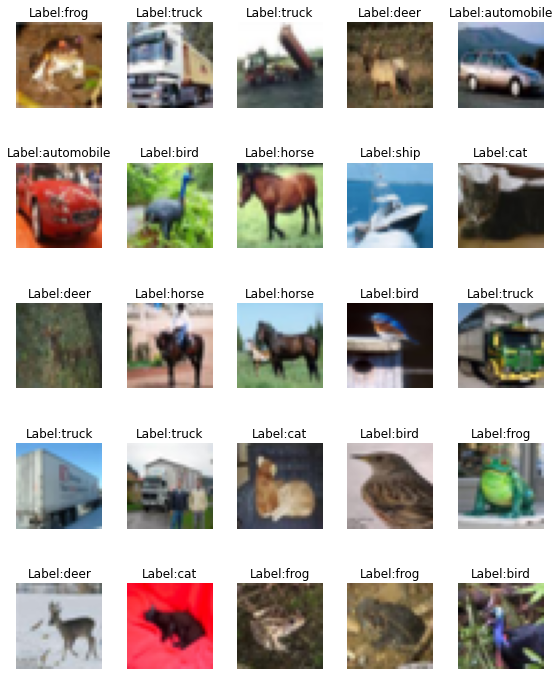

In [8]:
utils.visualize_data(viz_data,classes)

## Prepare dataset, apply transform and prepare Dataloader

In [9]:
train_transform = albumentation_transform(train=True, mean=mean, stddev=stddev)
test_transform = albumentation_transform(train=False, mean=mean, stddev=stddev)

In [10]:
train_dataset = CIFAR10.cifar10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10.cifar10(root='./data', train=False, download=True, transform=test_transform)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 133, 133])


(-0.5, 132.5, 132.5, -0.5)

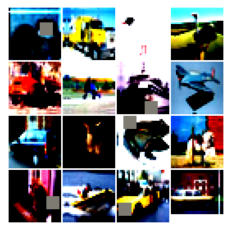

In [11]:
sample_images, sample_labels = next(iter(train_loader))
grid_image = torchvision.utils.make_grid(sample_images[:16], nrow=4, padding=1, pad_value=1)
print(grid_image.shape)
plt.imshow(grid_image.permute(1,2,0))
plt.axis('off')

## Model

### Network model creation and summary

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available device:",device)
# model = resnet.ResNet18('LayerNorm').to(device)
model = MixedResNet9().to(device)
summary(model, input_size=(3, 32, 32))

Available device: cuda
MixedResnet model is now loaded.
Conv + Maxpool + BN + Relu every layer. Resnet blocks every alternate layer- 1st and 3rd layers.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

## Find optimum learning rate using LRFinder

MixedResnet model is now loaded.
Conv + Maxpool + BN + Relu every layer. Resnet blocks every alternate layer- 1st and 3rd layers.



Learning rate search finished. See the graph with {finder_name}.plot()
Best Loss observed at LR= 0.0363925


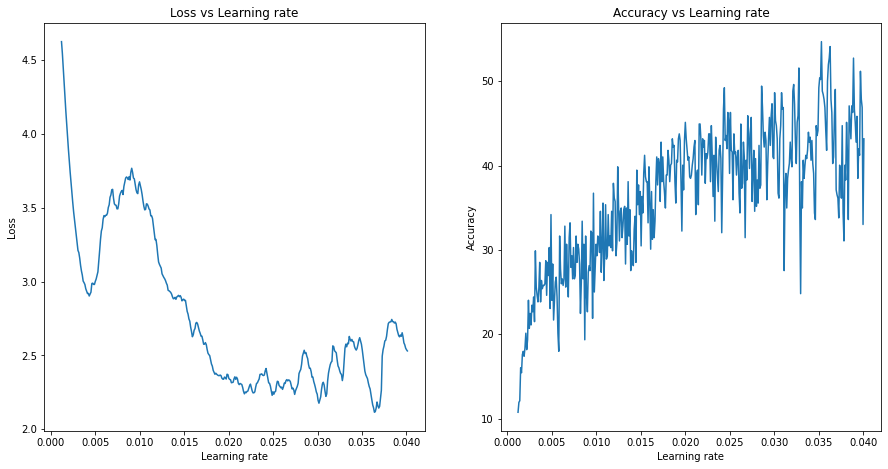

In [13]:
net = MixedResNet9().to(device)
criterion = nn.CrossEntropyLoss()
# Optimum LR for custom_model = 0.015
optimizer = optim.SGD(net.parameters(), lr=0.001, weight_decay=0.001)
lr_finder = LRFinder(net, optimizer, criterion, device)
#Run the range test
lr_finder.range_test(train_loader, end_lr=0.04, num_iter=400, step_mode="linear")
print("Best Loss observed at LR=",lr_finder.history['lr'][lr_finder.history['Loss'].index(lr_finder.best_loss)])
lr_finder.plot(skip_start=0, skip_end=0, log_lr=False)
lr_finder.reset()

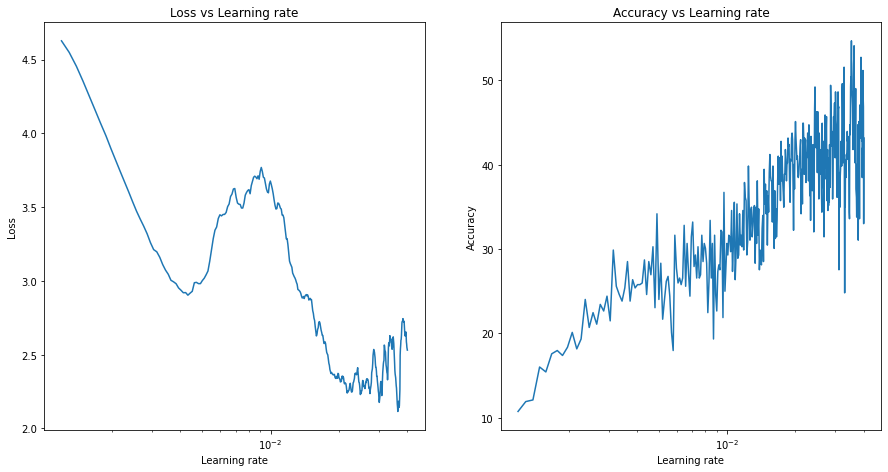

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8c5e11c90>,
      dtype=object)

In [14]:
lr_finder.plot(skip_start=0, skip_end=0, log_lr=True)

## Train model

In [13]:
EPOCHS = 24
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
l1_lambda=0
l2_lambda=0

# Optimization algorithm from torch.optim
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=l2_lambda)
# Loss condition
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr=0.02, total_steps=None, epochs=EPOCHS, steps_per_epoch=len(train_loader), pct_start=5/EPOCHS, 
                       base_momentum=0.85, max_momentum=0.95, div_factor=10, final_div_factor=1, last_epoch=-1)

for epochs in range(EPOCHS):
    print(f"Epoch: {epochs}")
    train_acc_delta, train_loss_delta = train(model, device, train_loader, optimizer, criterion, l1_lambda,scheduler)
    test_acc_delta, test_loss_delta = test(model, device, test_loader, criterion)
    # scheduler.step(test_loss_delta)

    train_accuracy.append(round(train_acc_delta, 2))
    train_loss.append(round(train_loss_delta, 4))
    test_accuracy.append(round(test_acc_delta, 2))
    test_loss.append(round(test_loss_delta, 4))

Epoch: 0
Train set: Epoch Accuracy: 37.85  Epoch Loss: 2.0856
Test set: Epoch Accuracy: 49.57  Epoch Loss: 1.471
Epoch: 1
Train set: Epoch Accuracy: 56.52  Epoch Loss: 1.2645
Test set: Epoch Accuracy: 59.55  Epoch Loss: 1.1799
Epoch: 2
Train set: Epoch Accuracy: 60.58  Epoch Loss: 1.2451
Test set: Epoch Accuracy: 60.72  Epoch Loss: 1.4275
Epoch: 3
Train set: Epoch Accuracy: 67.17  Epoch Loss: 1.0772
Test set: Epoch Accuracy: 63.09  Epoch Loss: 1.6098
Epoch: 4
Train set: Epoch Accuracy: 71.14  Epoch Loss: 1.0199
Test set: Epoch Accuracy: 68.38  Epoch Loss: 1.0433
Epoch: 5
Train set: Epoch Accuracy: 76.89  Epoch Loss: 0.7534
Test set: Epoch Accuracy: 78.74  Epoch Loss: 0.6609
Epoch: 6
Train set: Epoch Accuracy: 79.23  Epoch Loss: 0.6651
Test set: Epoch Accuracy: 74.58  Epoch Loss: 0.8048
Epoch: 7
Train set: Epoch Accuracy: 81.38  Epoch Loss: 0.5955
Test set: Epoch Accuracy: 73.03  Epoch Loss: 0.9967
Epoch: 8
Train set: Epoch Accuracy: 83.17  Epoch Loss: 0.5116
Test set: Epoch Accuracy: 8

## Results

### Train/Test accuracy and loss versus epochs

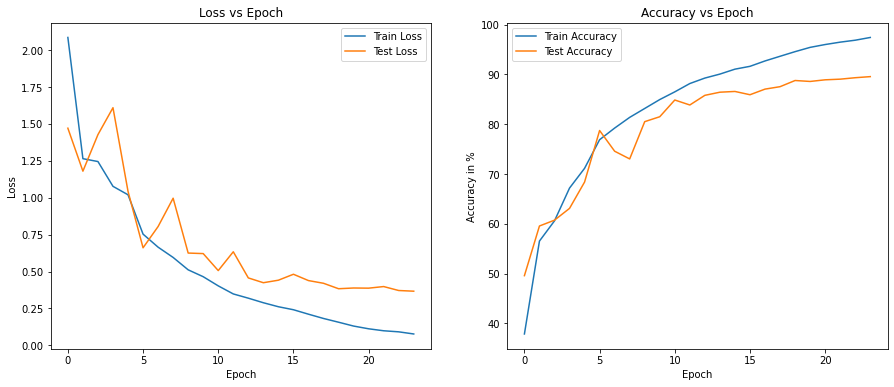

<Figure size 432x288 with 0 Axes>

In [14]:
utils.draw_loss_accuracy_graph(train_loss, test_loss, train_accuracy, test_accuracy)

### Misclassified Images

In [15]:
label_incorrect, prediction_incorrect, \
images_incorrect = utils.capture_incorrect_classified_samples(model, device, test_loader)

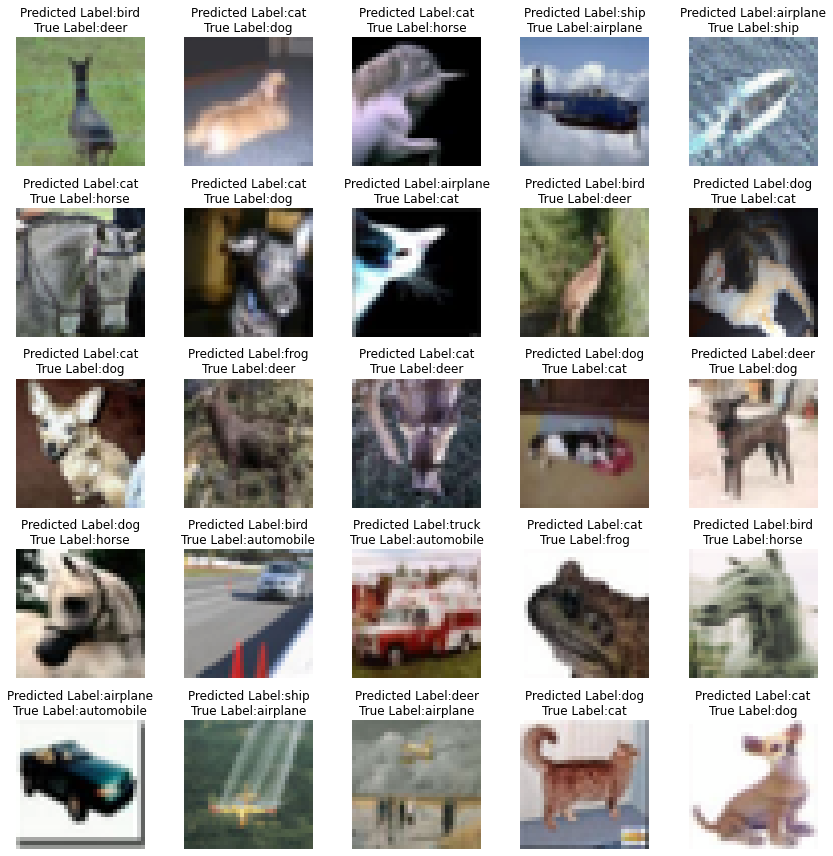

In [16]:
denormalized_images = utils.denormalize(images_incorrect, mean, stddev)
utils.show_incorrect_images(label_incorrect, prediction_incorrect, denormalized_images, classes)

## GradCAM on misclassified images

In [17]:
resnet_model_dict = dict(type='resnet', arch=model, layer_name='layer3', input_size=(32,32))
resnet_gradcam = gradcam.GradCAM(resnet_model_dict)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


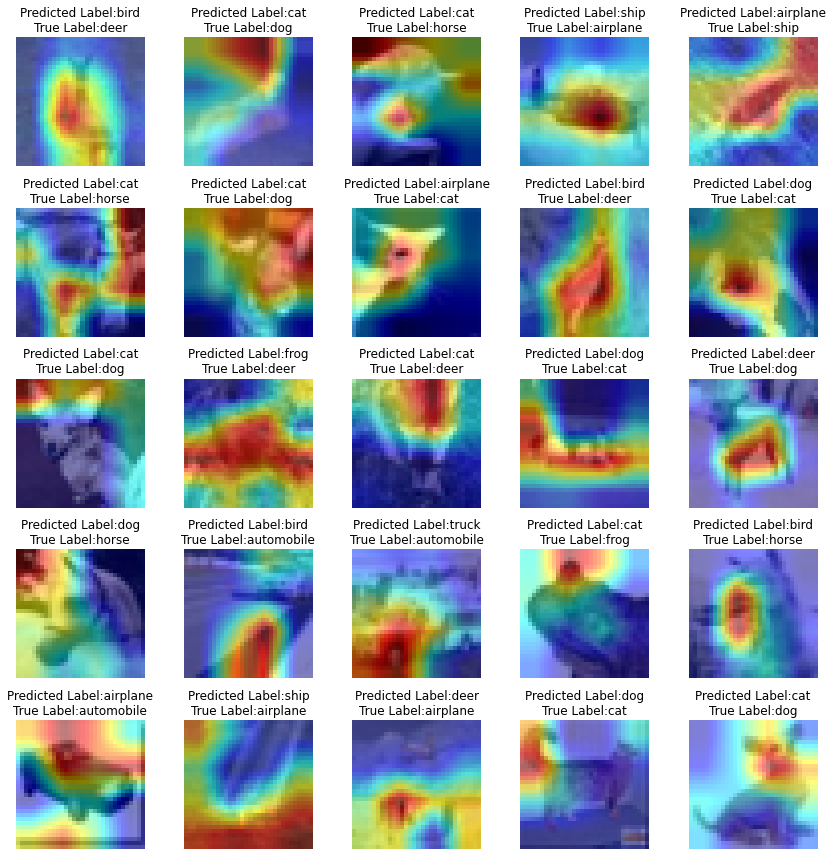

In [18]:
gradcam_utils.show_gradcam_images(resnet_gradcam, images_incorrect, label_incorrect, \
                    prediction_incorrect, classes, mean, stddev, device)